# Nursing Data Analysis

###### Tae Ken Kim

Say that you are a government official at some US state, and you are interested in getting more Registered Nurses for your state. After all, there is a shortage of nurses in the US.(quote) Using publicly availiable data, lets develope some insights into the nursing shortage.

## NSSRN National Sample Survey of Registered Nurses

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyreadstat
import seaborn as sns
import math
import copy
from time import sleep
from tqdm import tqdm
import random
import scipy.stats as stats
from state_name import census_and_regions

[state_census, region, region_merge, region_sep] = census_and_regions()
df_2018, meta_2018 = pyreadstat.read_sas7bdat('NSSRN2018_SAS_encoded_package\\NSSRN_2018_PUF.sas7bdat')

df_2018 will contain all of the survey data. We are interested in three measures: the graduated, first licensed, and currently practicing states of registered nurses. Some of the survey results give states as regions (D1, D4, D8, D9), but it is not consistent in its reporting style.

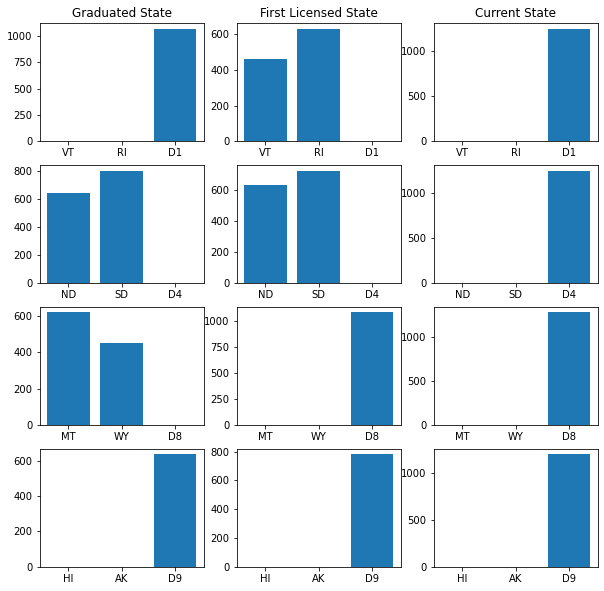

In [2]:
titles=['Graduated State', 'First Licensed State', 'Current State']
varnames=['ED_NDLOC_ST_PUF','ED_FRN_ST_PUF','PN_LOC_ST_PUF']
fig, ax = plt.subplots(4,3,figsize=(10,10))
for vi, vn in enumerate(varnames):    
    region_plots=[]
    for key in list(region.keys()):
        temp=[df_2018[df_2018[vn]==st].shape[0] for st in region[key]]
        temp.append(df_2018[df_2018[vn]==key].shape[0])
        region_plots.append(temp)
        
    
    for i in range(4):
        key = list(region.keys())[i]
        xlabel = copy.copy(region[key])
        xlabel.append(key)
        
        ax[i,vi].bar(xlabel,region_plots[i])
        
    ax[0,vi].set_title(titles[vi])

Since current state is only reported at the regional level for these states, it makes sense to combine each region's data into one group for all states in the region.
States in D1(RI, VT), D4(ND, SD), and D8(MT, WY) are geographically close, so combining these states isn't too far-fetched. D9(AK, HI) states are only reported at the regional level for all three metrics so we have no other choice.

In [3]:
for key in region.keys():
    for st in region[key]:
        for vn in varnames:
            df_2018.loc[df_2018[vn]==st,vn]=key

Now, AK and HI are obviously very different states, so any insights drawn from D9 might be useless. However, since we will be looking at the rates at which nurses enter and leave each state, and since they are both outside the contiguous United States, they will pose similar hurdles for people looking to transiton in/out of these states. Therefore, the insights drawn from D9 data might still prove useful.

Let's examine the relation between graduated state and first licensed state. I will be assuming that first licensed state will be the state where each nurse had their first job.

Percentage of graduates staying after graduation
------------------------------------------------
CA: 95%      LA: 95%      UT: 93%      D9: 92%      
NM: 92%      AR: 92%      MI: 91%      NV: 91%      
OK: 91%      MS: 91%      NJ: 90%      GA: 90%      
KS: 90%      SC: 90%      ME: 90%      CO: 89%      
OH: 89%      TX: 89%      IL: 88%      TN: 88%      
AL: 88%      CT: 88%      KY: 87%      NC: 87%      
WI: 87%      WV: 86%      D8: 86%      ID: 86%      
FL: 86%      OR: 86%      AZ: 86%      IN: 85%      
MA: 85%      NE: 85%      WA: 85%      MO: 84%      
D4: 84%      MN: 84%      MD: 83%      D1: 82%      
VA: 82%      DE: 82%      IA: 81%      PA: 80%      
NY: 76%      NH: 75%      DC: 57%      


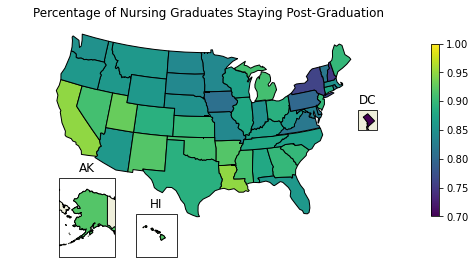

In [4]:
df_gfc = pd.DataFrame({'grad':df_2018['ED_NDLOC_ST_PUF'].value_counts(),'first':df_2018['ED_FRN_ST_PUF'].value_counts(),'current':df_2018['PN_LOC_ST_PUF'].value_counts()})
df_gfc.drop(index='.L',inplace=True)

graduated_state_axis = df_gfc['grad'].sort_values(ascending=False).index
first_state_axis = df_gfc['first'].sort_values(ascending=False).index
current_state_axis = df_gfc['current'].sort_values(ascending=False).index

"""heatmap - graduate vs first state"""
hm_gf_raw = np.zeros(shape=(df_gfc.shape[0],df_gfc.shape[0]),dtype=int) #y,x

for gsi,gs in enumerate(graduated_state_axis):
    s1 = df_2018.loc[lambda df:df['ED_NDLOC_ST_PUF']==gs,'ED_FRN_ST_PUF'].value_counts() # first state series filtered for graduated state    
    for fsi,fs in enumerate(graduated_state_axis):  #enumerate over gsa so x and y axis will have the same order
        try:
            hm_gf_raw[gsi][fsi] += s1[fs]
        except:
            pass
            
#normalize by the total graduate number
hm_gf = np.zeros(shape=(df_gfc.shape[0],df_gfc.shape[0]),dtype=int)
for gsi,gs in enumerate(graduated_state_axis): 
    total = sum(hm_gf_raw[gsi,:])
    if total>0:
        hm_gf[gsi,:]=hm_gf_raw[gsi,:]/total*100;   
       
    
#report results in order

gf_stay_i = np.flip(np.argsort([hm_gf[i,i] for i in range(df_gfc.shape[0])]))

print("Percentage of graduates staying after graduation")
print("------------------------------------------------")

report = ''
for i in range(df_gfc.shape[0]):
    report+='{}: {}%      '.format(graduated_state_axis[gf_stay_i[i]],hm_gf[gf_stay_i[i],gf_stay_i[i]])
    if i%4 == 3:
        print(report)
        report = ''
else:
    if i%4 != 3:
        print(report)

    

#draw heatmap   
map_data = {}
cmap = plt.cm.get_cmap('viridis')
data_range = [0.7, 1]
map_title = 'Percentage of Nursing Graduates Staying Post-Graduation'
for i in range(df_gfc.shape[0]):
    stname = graduated_state_axis[i]
    if stname in region.keys():
        for st in region[stname]:            
            map_data[st]=cmap((hm_gf[i,i]-70)/30)
    else:
        map_data[stname]=cmap((hm_gf[i,i]-70)/30)   


from us_map import make_map
make_map(map_data,cmap,data_range,map_title)

As expected, all states get majority of their own graduates to stay for their first jobs. So perhaps obvious first recommendation for any state is:
* **Increase the number of nursing students in the state**

Weighting by the total graduates of each state(as we did above) gives us a origin centric metric: it measures the percentage of graduates from each state(origin) that will go to a particular state(destination). If we normalize by first licensed state, it will give a destination centric metric: for each state's nursing population, it will tell us where they graduated from.

If we are interested in boosting the nursing population of a state by attracting more nurses from other regions, we do not care about the destination of this state's graduates, but rather the origins of the state's nursing population. i.e. If many first time nurses in NJ went to nursing school in PA, NJ may decide to redouble their recruiting efforts in PA. Here is a heatmap of this destination centric metric.

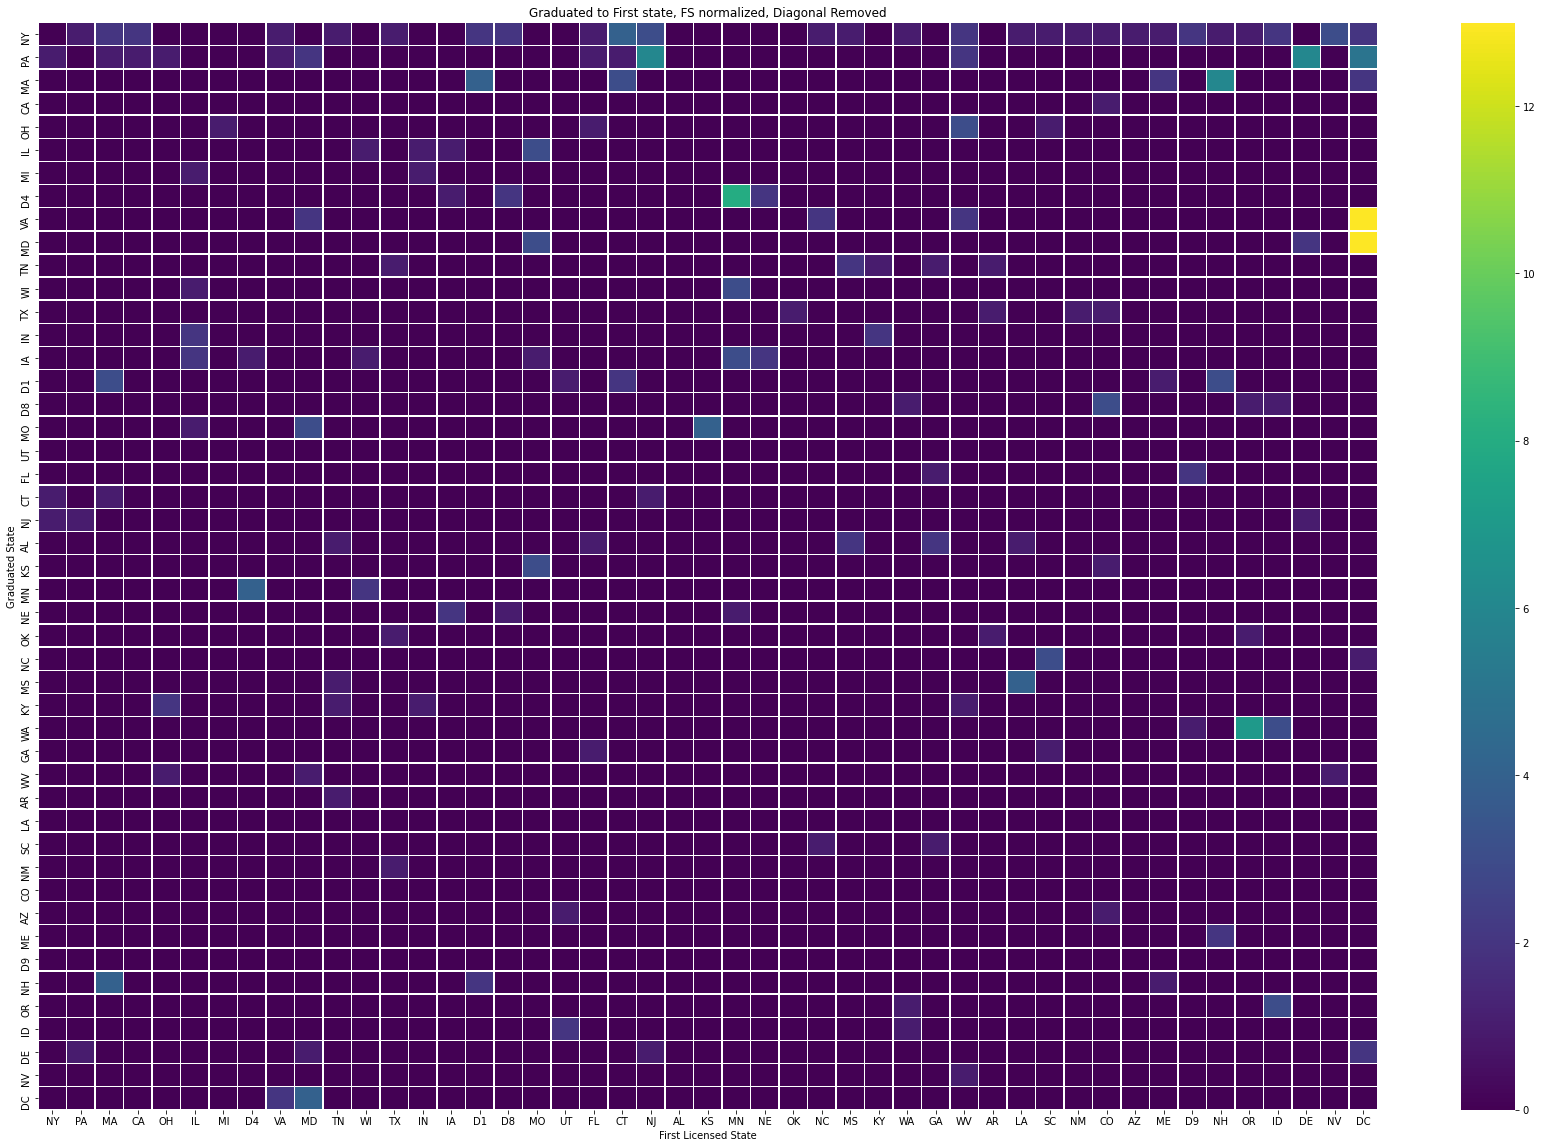

In [5]:
hm_fg = np.zeros(shape=(df_gfc.shape[0],df_gfc.shape[0]),dtype=int)
for gsi,gs in enumerate(graduated_state_axis): 
    total = sum(hm_gf_raw[:,gsi])
    if total>0:
        hm_fg[:,gsi]=hm_gf_raw[:,gsi]/total*100;

hm_fg_diag = copy.deepcopy(hm_fg)

for i in range(df_gfc.shape[0]):
    hm_fg_diag[i,i]=0
        
fig2, ax2 = plt.subplots(figsize=(30,20))
ax2 = sns.heatmap(hm_fg_diag, linewidth=0.5,cmap="viridis",xticklabels=graduated_state_axis,yticklabels=graduated_state_axis)
plt.title('Graduated to First state, FS normalized, Diagonal Removed')
plt.xlabel("First Licensed State")
plt.ylabel("Graduated State")
plt.show()  

Looking at few standouts, it certainly seems that geographic distance plays a big role in nursing graduates deciding to cross state borders. i.e. DC gets lots of nurses from MD and VA, OR from WA, MD from the Dakotas. We can measure the degree to which geographic distance plays a role in nurses' decisions to move states, by finding the average distance of out-of-state graduate nurses for each state.

Average Distance Moved by Out-of-State Graduates (mi)
------------------------------------------------
D9: 2050 mi     CA: 1040 mi     NV:  953 mi     AZ:  881 mi     
WA:  868 mi     D8:  677 mi     NM:  660 mi     OR:  645 mi     
UT:  623 mi     FL:  573 mi     TX:  564 mi     CO:  530 mi     
ID:  505 mi     AR:  494 mi     OK:  441 mi     MI:  436 mi     
ME:  384 mi     AL:  357 mi     GA:  349 mi     LA:  343 mi     
NC:  341 mi     NE:  332 mi     NY:  322 mi     D4:  315 mi     
D1:  310 mi     WV:  303 mi     MO:  297 mi     WI:  292 mi     
TN:  291 mi     SC:  285 mi     MS:  284 mi     IA:  279 mi     
OH:  271 mi     VA:  255 mi     MN:  248 mi     KS:  241 mi     
IN:  225 mi     MD:  222 mi     IL:  221 mi     KY:  220 mi     
PA:  215 mi     NH:  187 mi     CT:  176 mi     MA:  169 mi     
NJ:  157 mi     DE:  129 mi     DC:  126 mi     


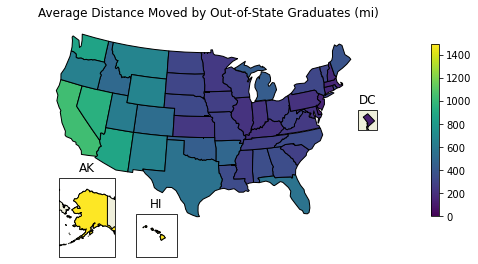

In [6]:
from distance import distance
from distance import midpoint

#function to get locations of states and regions (weighted by population for regions)
def locate(st):
    if st in region.keys():
        loc1 = state_census.loc[region[st][0],['LATITUDE','LONGITUDE']].to_numpy()
        loc2 = state_census.loc[region[st][1],['LATITUDE','LONGITUDE']].to_numpy()
        pop1 = state_census.loc[region[st][0],['POPULATION']]
        pop2 = state_census.loc[region[st][1],['POPULATION']]
        return midpoint(loc1,loc2,pop1,pop2)
    else:
        return state_census.loc[st,['LATITUDE','LONGITUDE']].to_numpy()



avg_dist = {}

for fsi,fs in enumerate(graduated_state_axis):  #we iterate fs over gs because the hm_gf array was with gs indices

    n_total = sum(hm_gf_raw[:,fsi])-hm_gf_raw[fsi,fsi]
    dist_total = 0    
    fsloc = locate(fs)
    
    for gsi, gs in enumerate(graduated_state_axis):
        if gs != fs:
            gsloc = locate(gs)
            dist_total += distance(fsloc,gsloc)*hm_gf_raw[gsi,fsi]
 
    avg_dist[fs] = dist_total/n_total*0.621371

# report text
dist_i = np.flip(np.argsort(list(avg_dist.values())))

print("Average Distance Moved by Out-of-State Graduates (mi)")
print("------------------------------------------------")

report = ''
for i in range(df_gfc.shape[0]):
    report+='{}: {:4.0f} mi     '.format(graduated_state_axis[dist_i[i]],avg_dist[graduated_state_axis[dist_i[i]]])
    if i%4 == 3:
        print(report)
        report = ''
else:
    if i%4 != 3:
        print(report)


#draw map
map_data = {} #colors
cmap = plt.cm.get_cmap('viridis')
data_range = [0, 1500]
map_title = 'Average Distance Moved by Out-of-State Graduates (mi)'
for i in range(df_gfc.shape[0]):
    stname = graduated_state_axis[i]
    if stname in region.keys():
        for st in region[stname]:            
            map_data[st]=cmap(avg_dist[stname]/1500)
    else:
        map_data[stname]=cmap(avg_dist[stname]/1500)   
        
from us_map import make_map
make_map(map_data,cmap,data_range,map_title)

The northeast seem to have shorter average distance, which makes sense, since population density is higher.

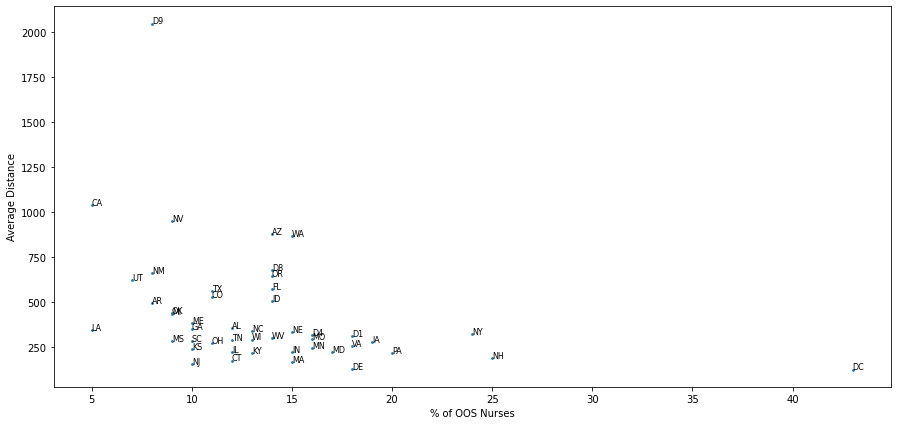

In [8]:
#scatter of %of out of state vs distance
fig, ax = plt.subplots(figsize=(15,7))
xlist=100-np.array([hm_gf[i,i] for i in range(df_gfc.shape[0])])
ylist=list(avg_dist.values())
ax.scatter(xlist,ylist,s=3)
ax.set_xlabel('% of OOS Nurses')
ax.set_ylabel('Average Distance')

for i, txt in enumerate(graduated_state_axis):
    ax.annotate(txt, (xlist[i], ylist[i]),fontsize=8)